In [276]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matlab.engine
from scipy.stats import norm


## Greeks


In [277]:
def delta(S, K, r, sigma_imp, T, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    if option_type == 'C':
        return norm.cdf(d1)
    elif option_type == 'P':
        return -norm.cdf(-d1)

def theta(S, K, r, sigma_imp, T, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    d2 = d1 - sigma_imp * np.sqrt(T)
    if option_type == 'C':
        return (-S * norm.pdf(d1) * sigma_imp) / (2 * np.sqrt(T)) -( r * K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'P':
        return (-S * norm.pdf(d1) * sigma_imp) / (2 * np.sqrt(T)) +( r * K * np.exp(-r * T) * norm.cdf(-d2))

def gamma(S, K, r, sigma_imp, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma_imp * np.sqrt(T))

def vega(S, K, r, sigma_imp, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def rho(S, K, r, sigma_imp, T, option_type):
    d2 = (np.log(S / K) + (r - 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    if option_type == 'C':
        return K * T * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'P':
        return -K * T * np.exp(-r * T) * norm.cdf(-d2)

In [278]:
with open('expirations_with_data.txt', 'r') as file:
    expirations = [line.strip() for line in file.readlines()]

In [279]:
#t0 = df['quote_datetime'].iloc[0].split()[0]]
t0 = "2021-04-26"
T = "2022-04-26" # 1 year from t0
t_dates = expirations
tau_days = [( datetime.strptime(t, '%Y-%m-%d') - datetime.strptime(t0, '%Y-%m-%d')).days for t in t_dates]
tau = [t / 365 for t in tau_days]
print(t_dates)
print(tau_days)
print(tau)


['2021-04-28', '2021-05-05', '2021-05-12', '2021-05-19', '2021-05-26', '2021-06-16', '2021-07-21', '2021-08-18', '2021-09-15', '2021-10-20', '2021-11-17', '2021-12-22']
[2, 9, 16, 23, 30, 51, 86, 114, 142, 177, 205, 240]
[0.005479452054794521, 0.024657534246575342, 0.043835616438356165, 0.06301369863013699, 0.0821917808219178, 0.13972602739726028, 0.2356164383561644, 0.31232876712328766, 0.38904109589041097, 0.4849315068493151, 0.5616438356164384, 0.6575342465753424]


In [280]:
index_count = 0

for expiration in expirations:
    df = pd.read_csv(fr'implied\vix_options_{expiration}.csv')
    tau_op =tau[index_count]
    for option in df.iterrows():
        option = option[1]
        option_type = option['option_type']
        S = option['underlying_bid']
        K = option['strike']
        r = 0.15370
        sigma_imp = option['implied_vol']
        option_delta = delta(S, K, r, sigma_imp, tau_op, option_type)
        option_theta = theta(S, K, r, sigma_imp, tau_op, option_type)
        option_gamma = gamma(S, K, r, sigma_imp, tau_op)
        option_vega = vega(S, K, r, sigma_imp, tau_op)
        option_rho = rho(S, K, r, sigma_imp, tau_op, option_type)
        df.loc[option.name, 'delta'] = option_delta
        df.loc[option.name, 'theta'] = option_theta
        df.loc[option.name, 'gamma'] = option_gamma
        df.loc[option.name, 'vega'] = option_vega
        df.loc[option.name, 'rho'] = option_rho
    df.to_csv(fr'impliedcalc\vix_options_{expiration}.csv', index=False)
    index_count += 1



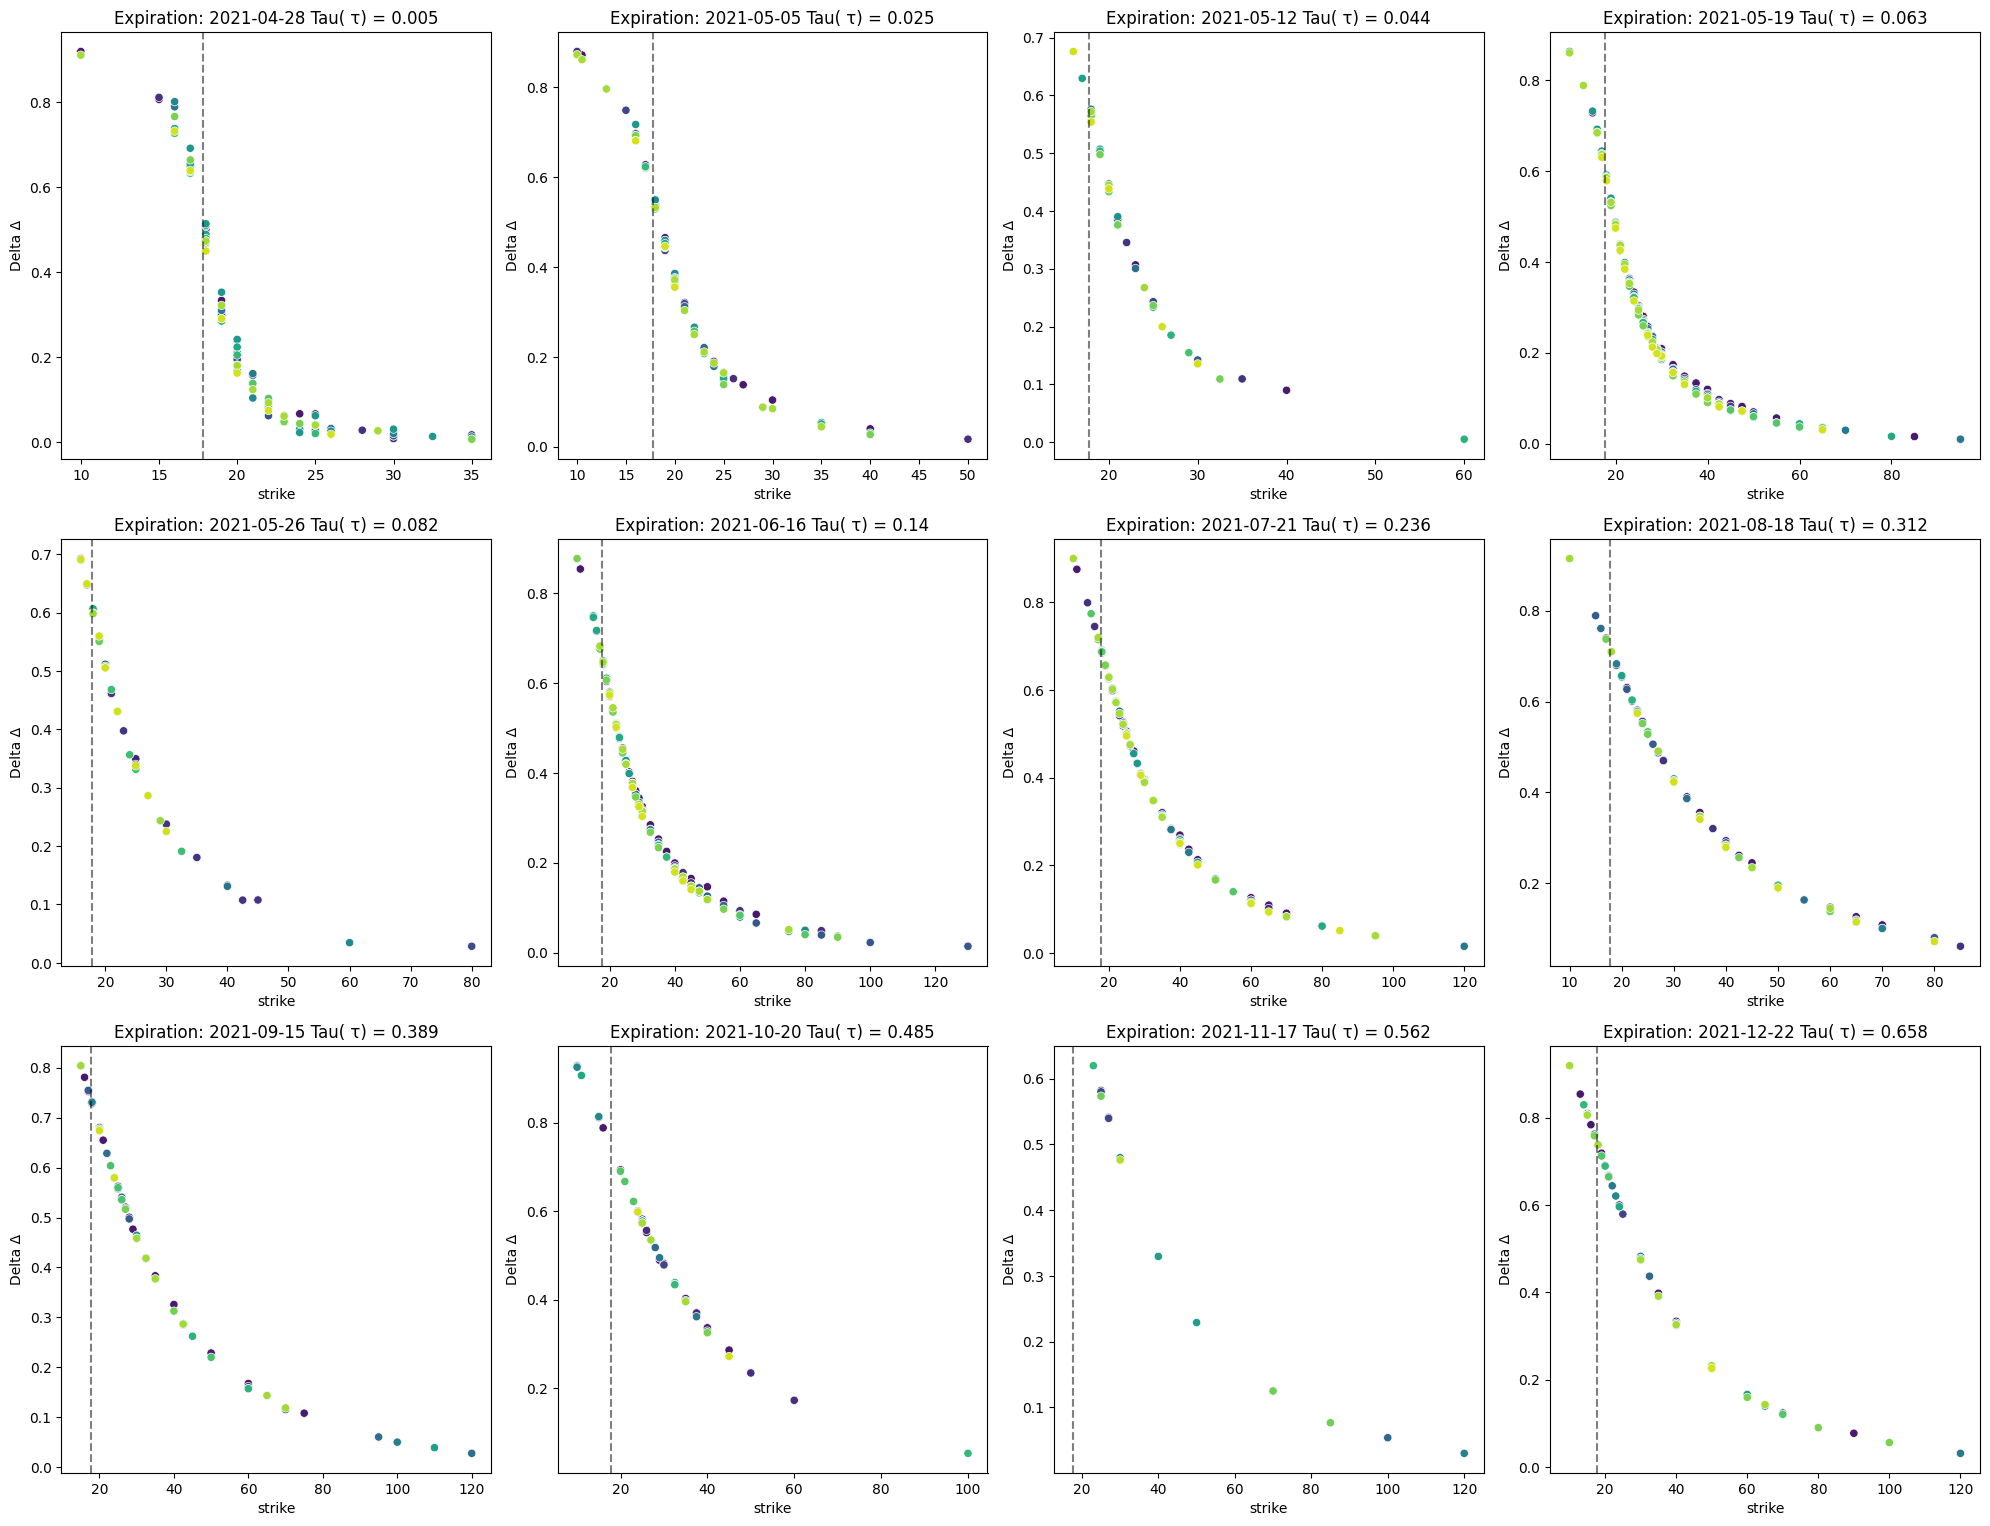

In [281]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='delta', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('Delta \u0394')
    axes[i].set_title(f'Expiration: {expiration} Tau( \u03C4) = {round(tau[i],3)}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

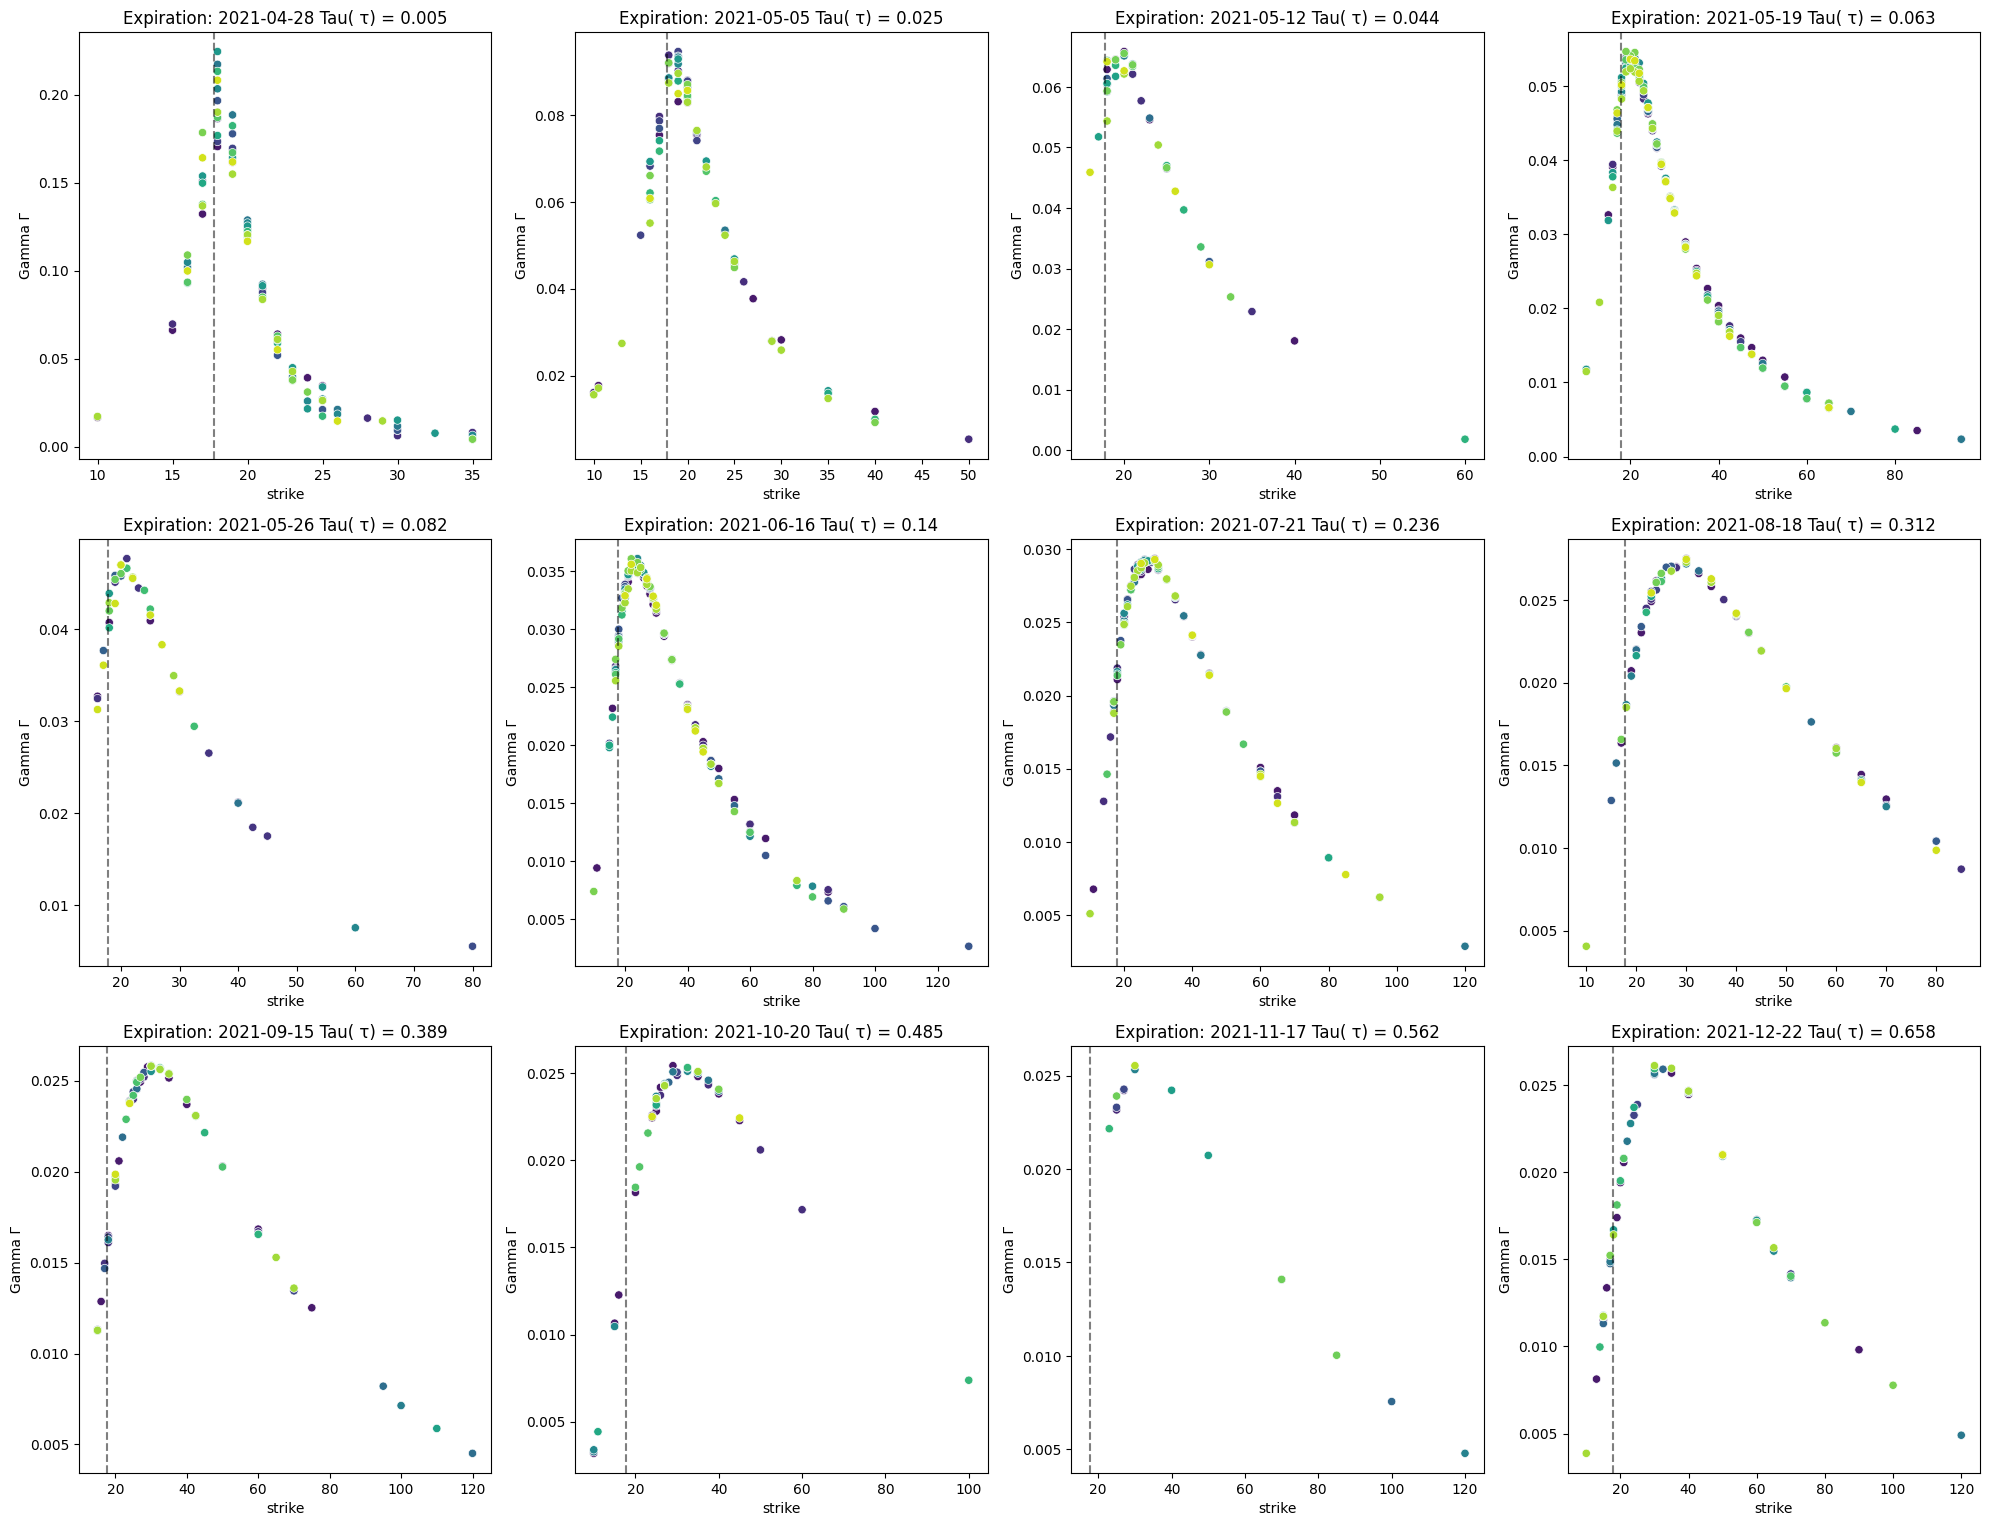

In [282]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='gamma', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('Gamma \u0393')
    axes[i].set_title(f'Expiration: {expiration} Tau( \u03C4) = {round(tau[i],3)}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

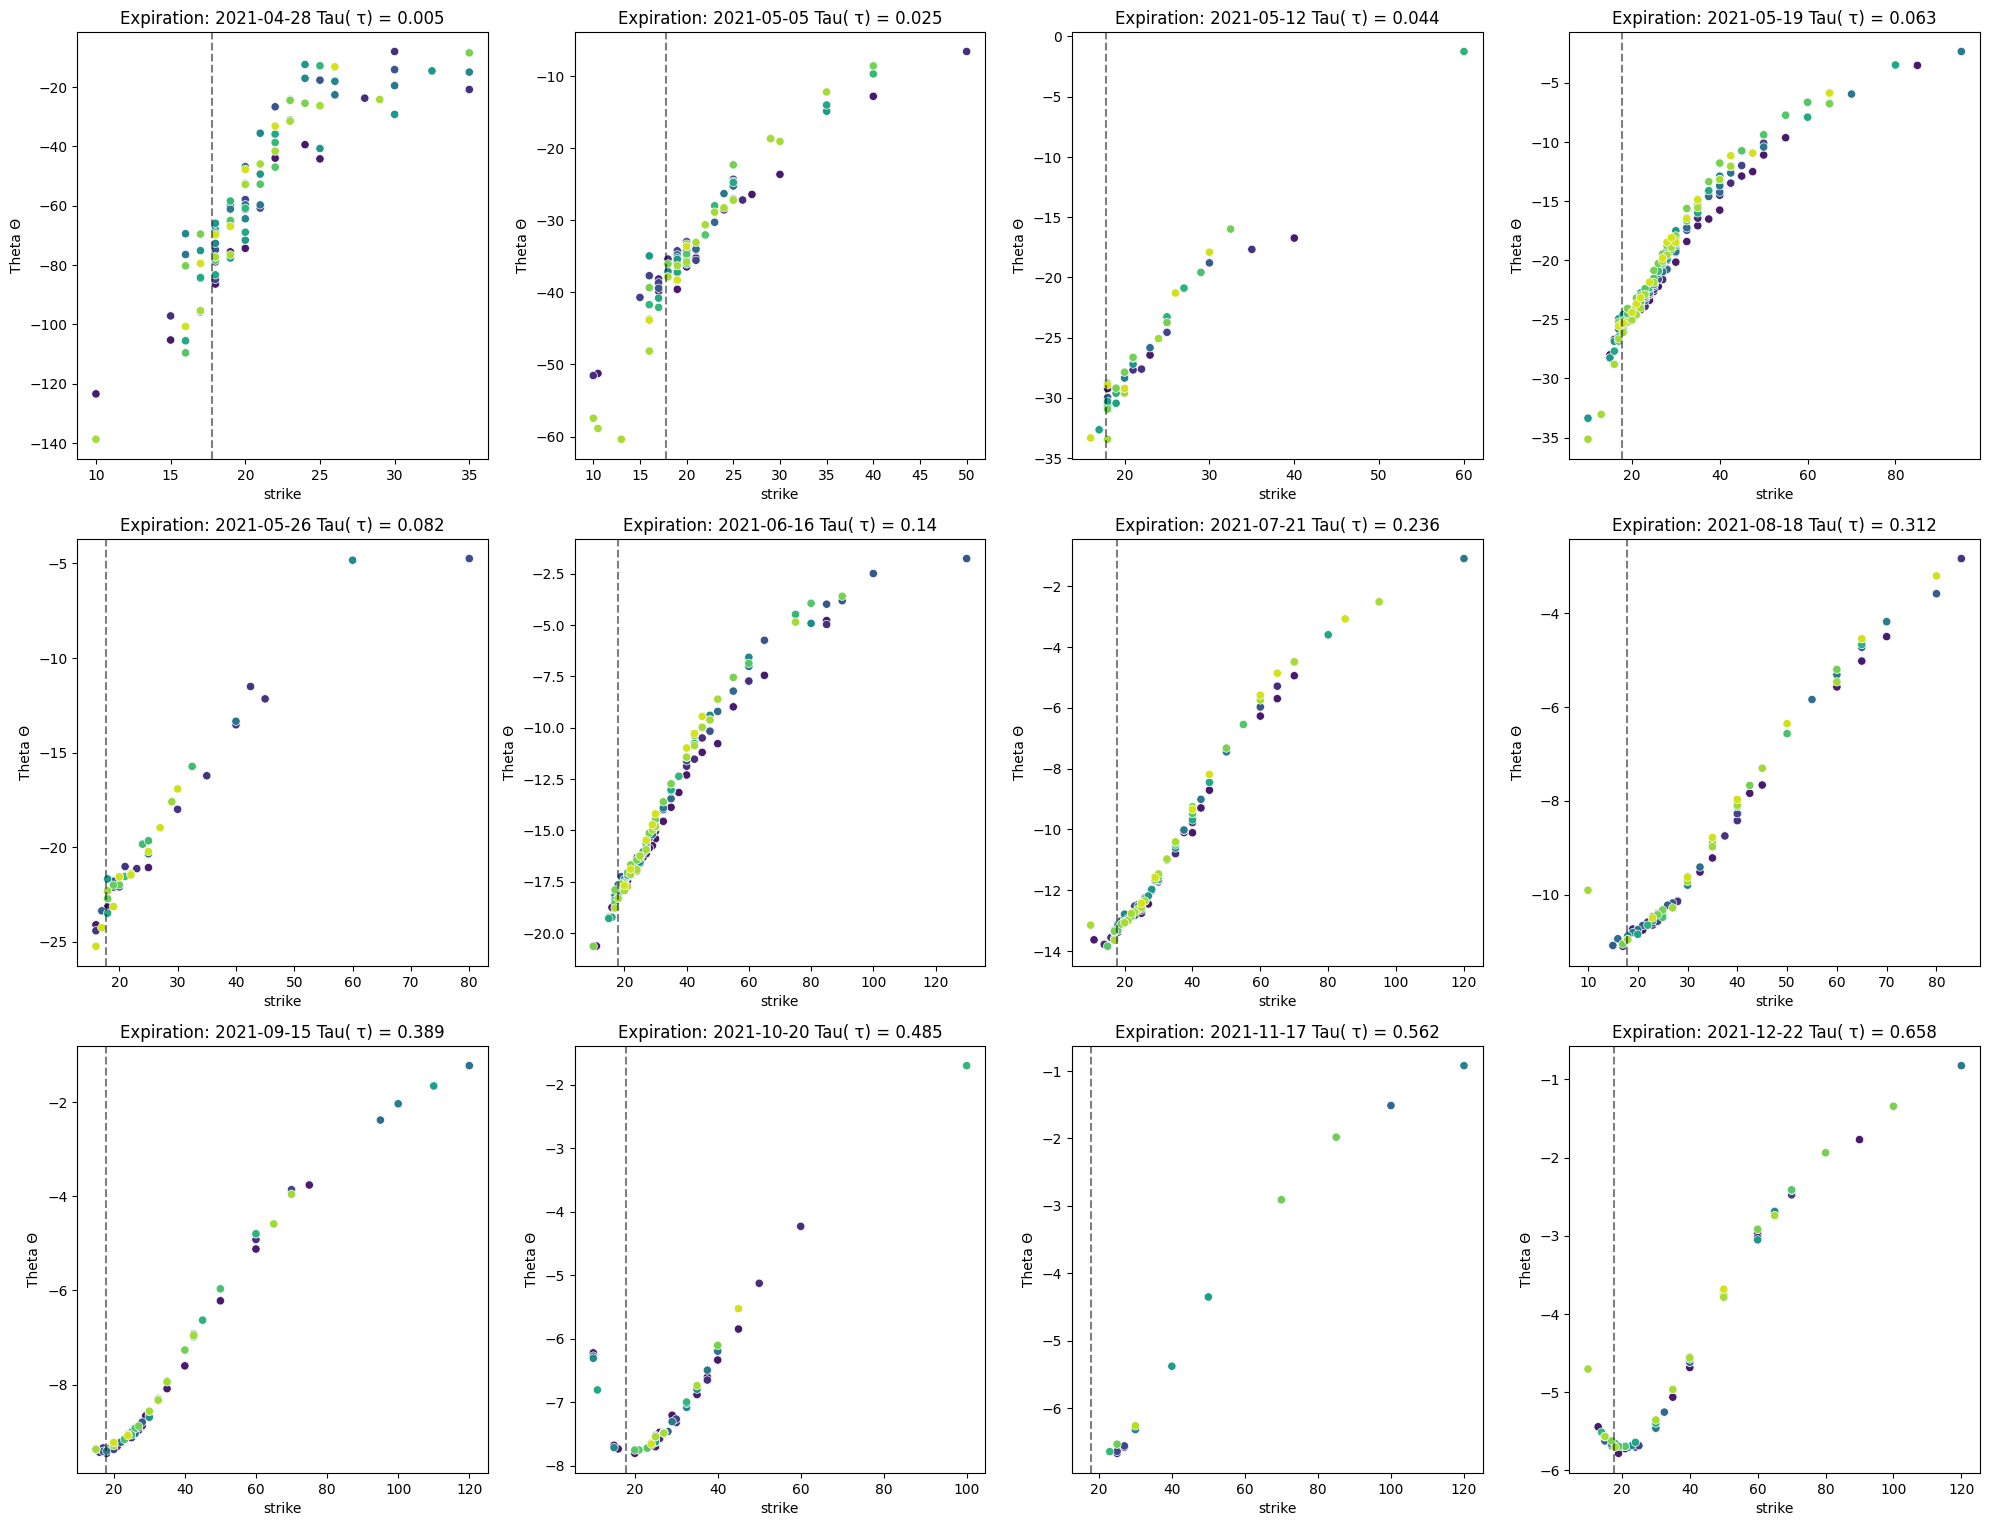

In [283]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='theta', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('Theta \u0398')
    axes[i].set_title(f'Expiration: {expiration} Tau( \u03C4) = {round(tau[i],3)}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

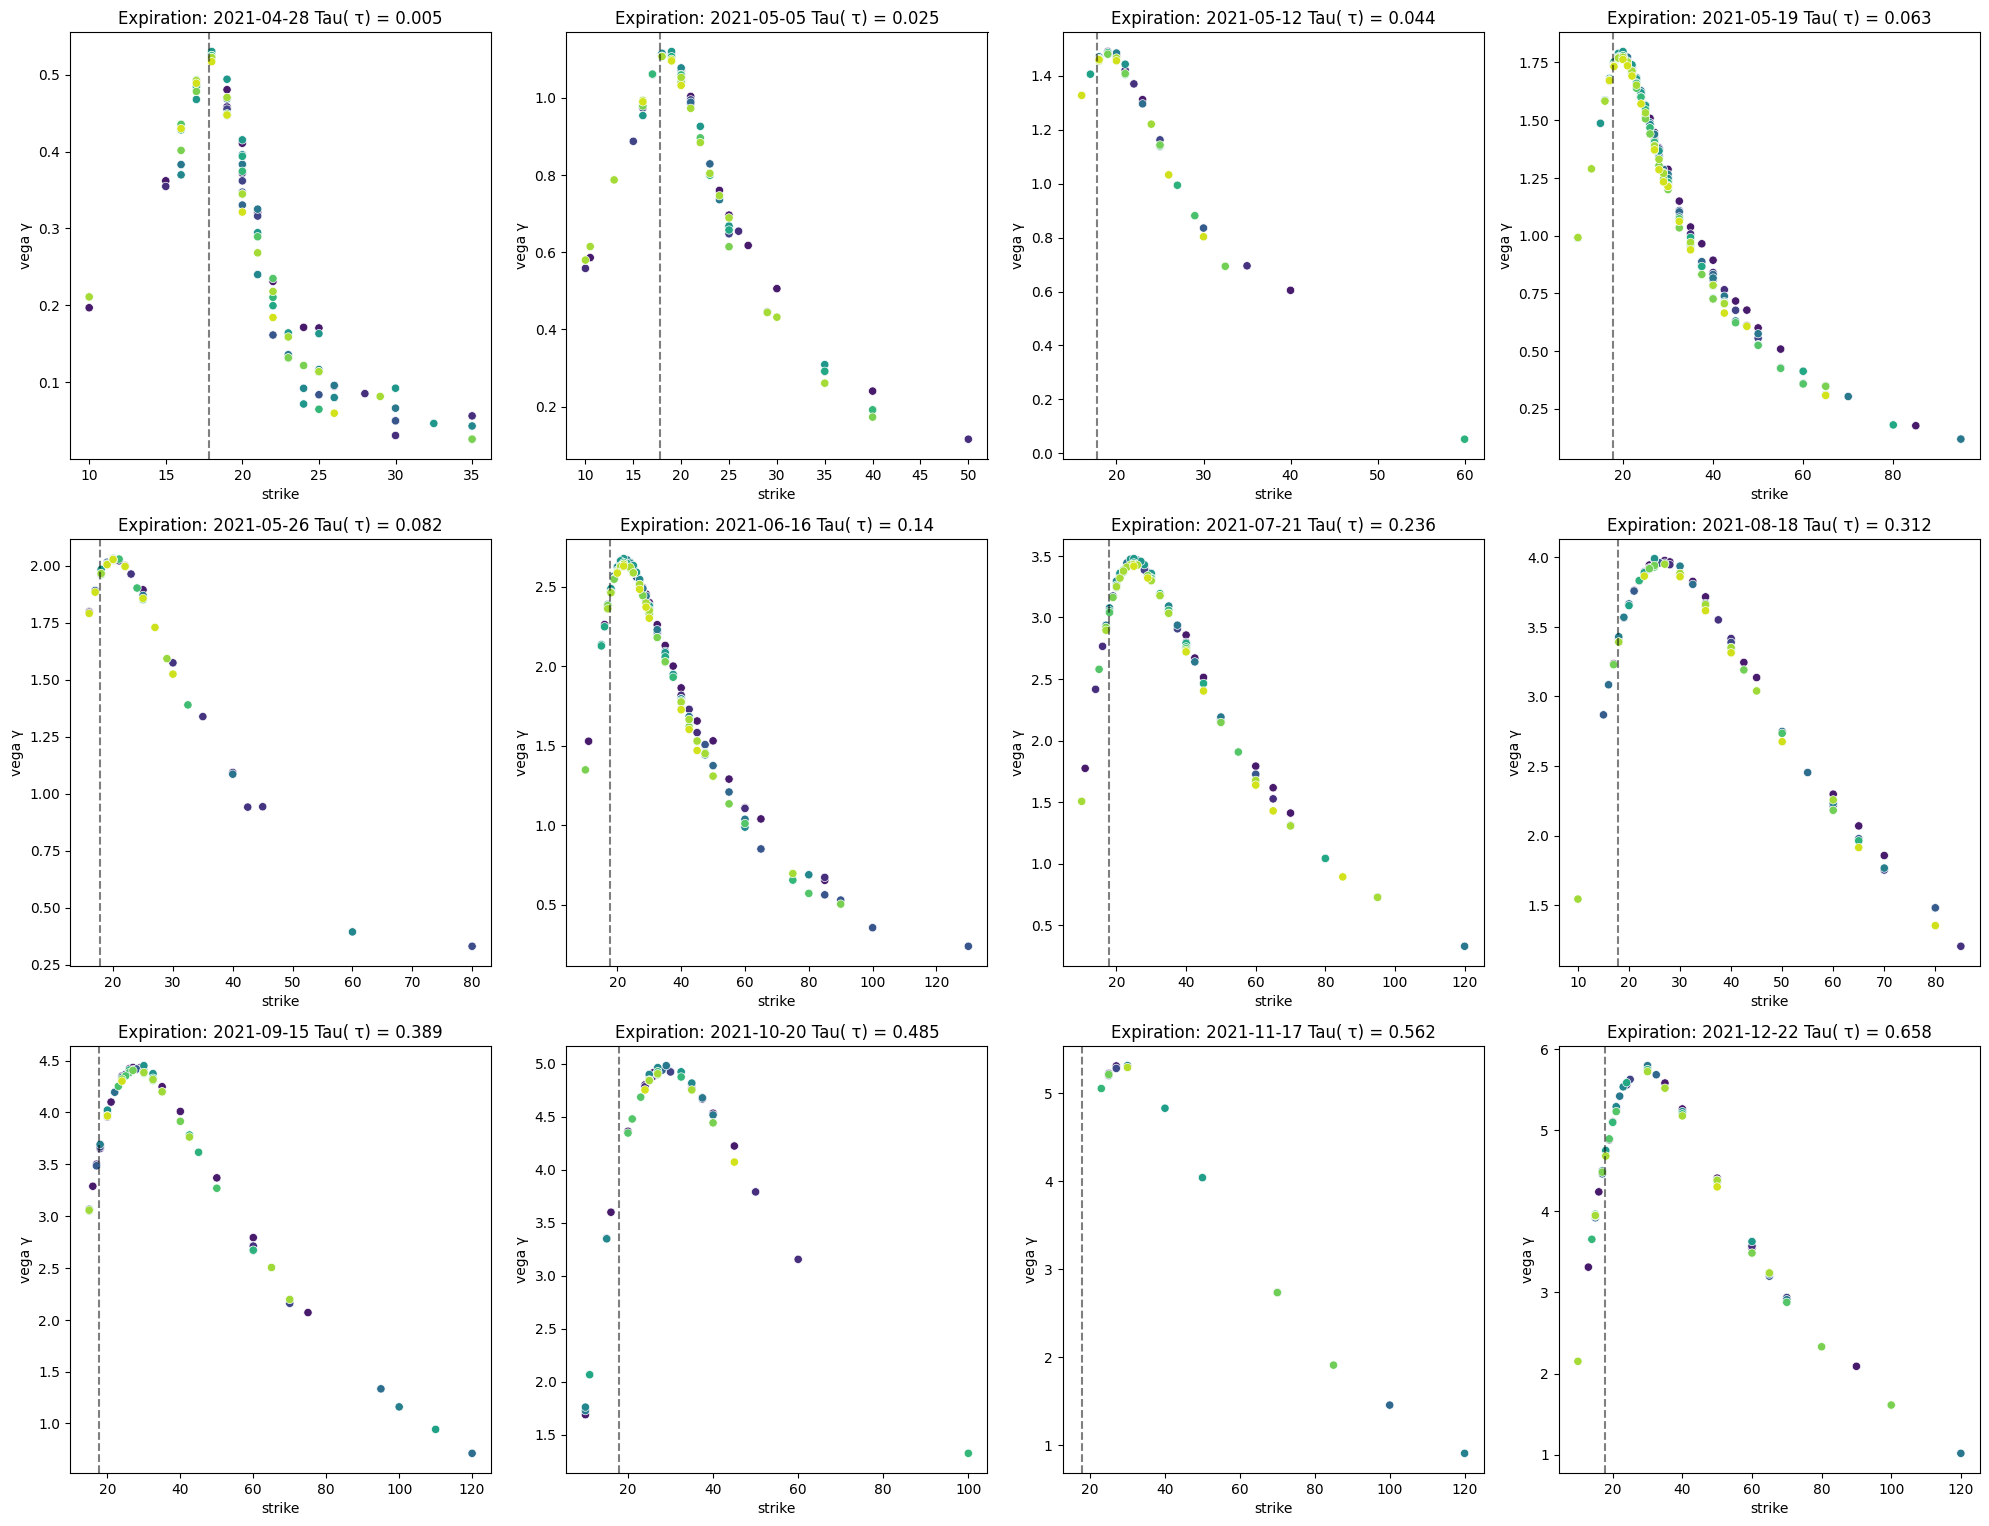

In [284]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='vega', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('vega \u03B3')
    axes[i].set_title(f'Expiration: {expiration} Tau( \u03C4) = {round(tau[i],3)}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

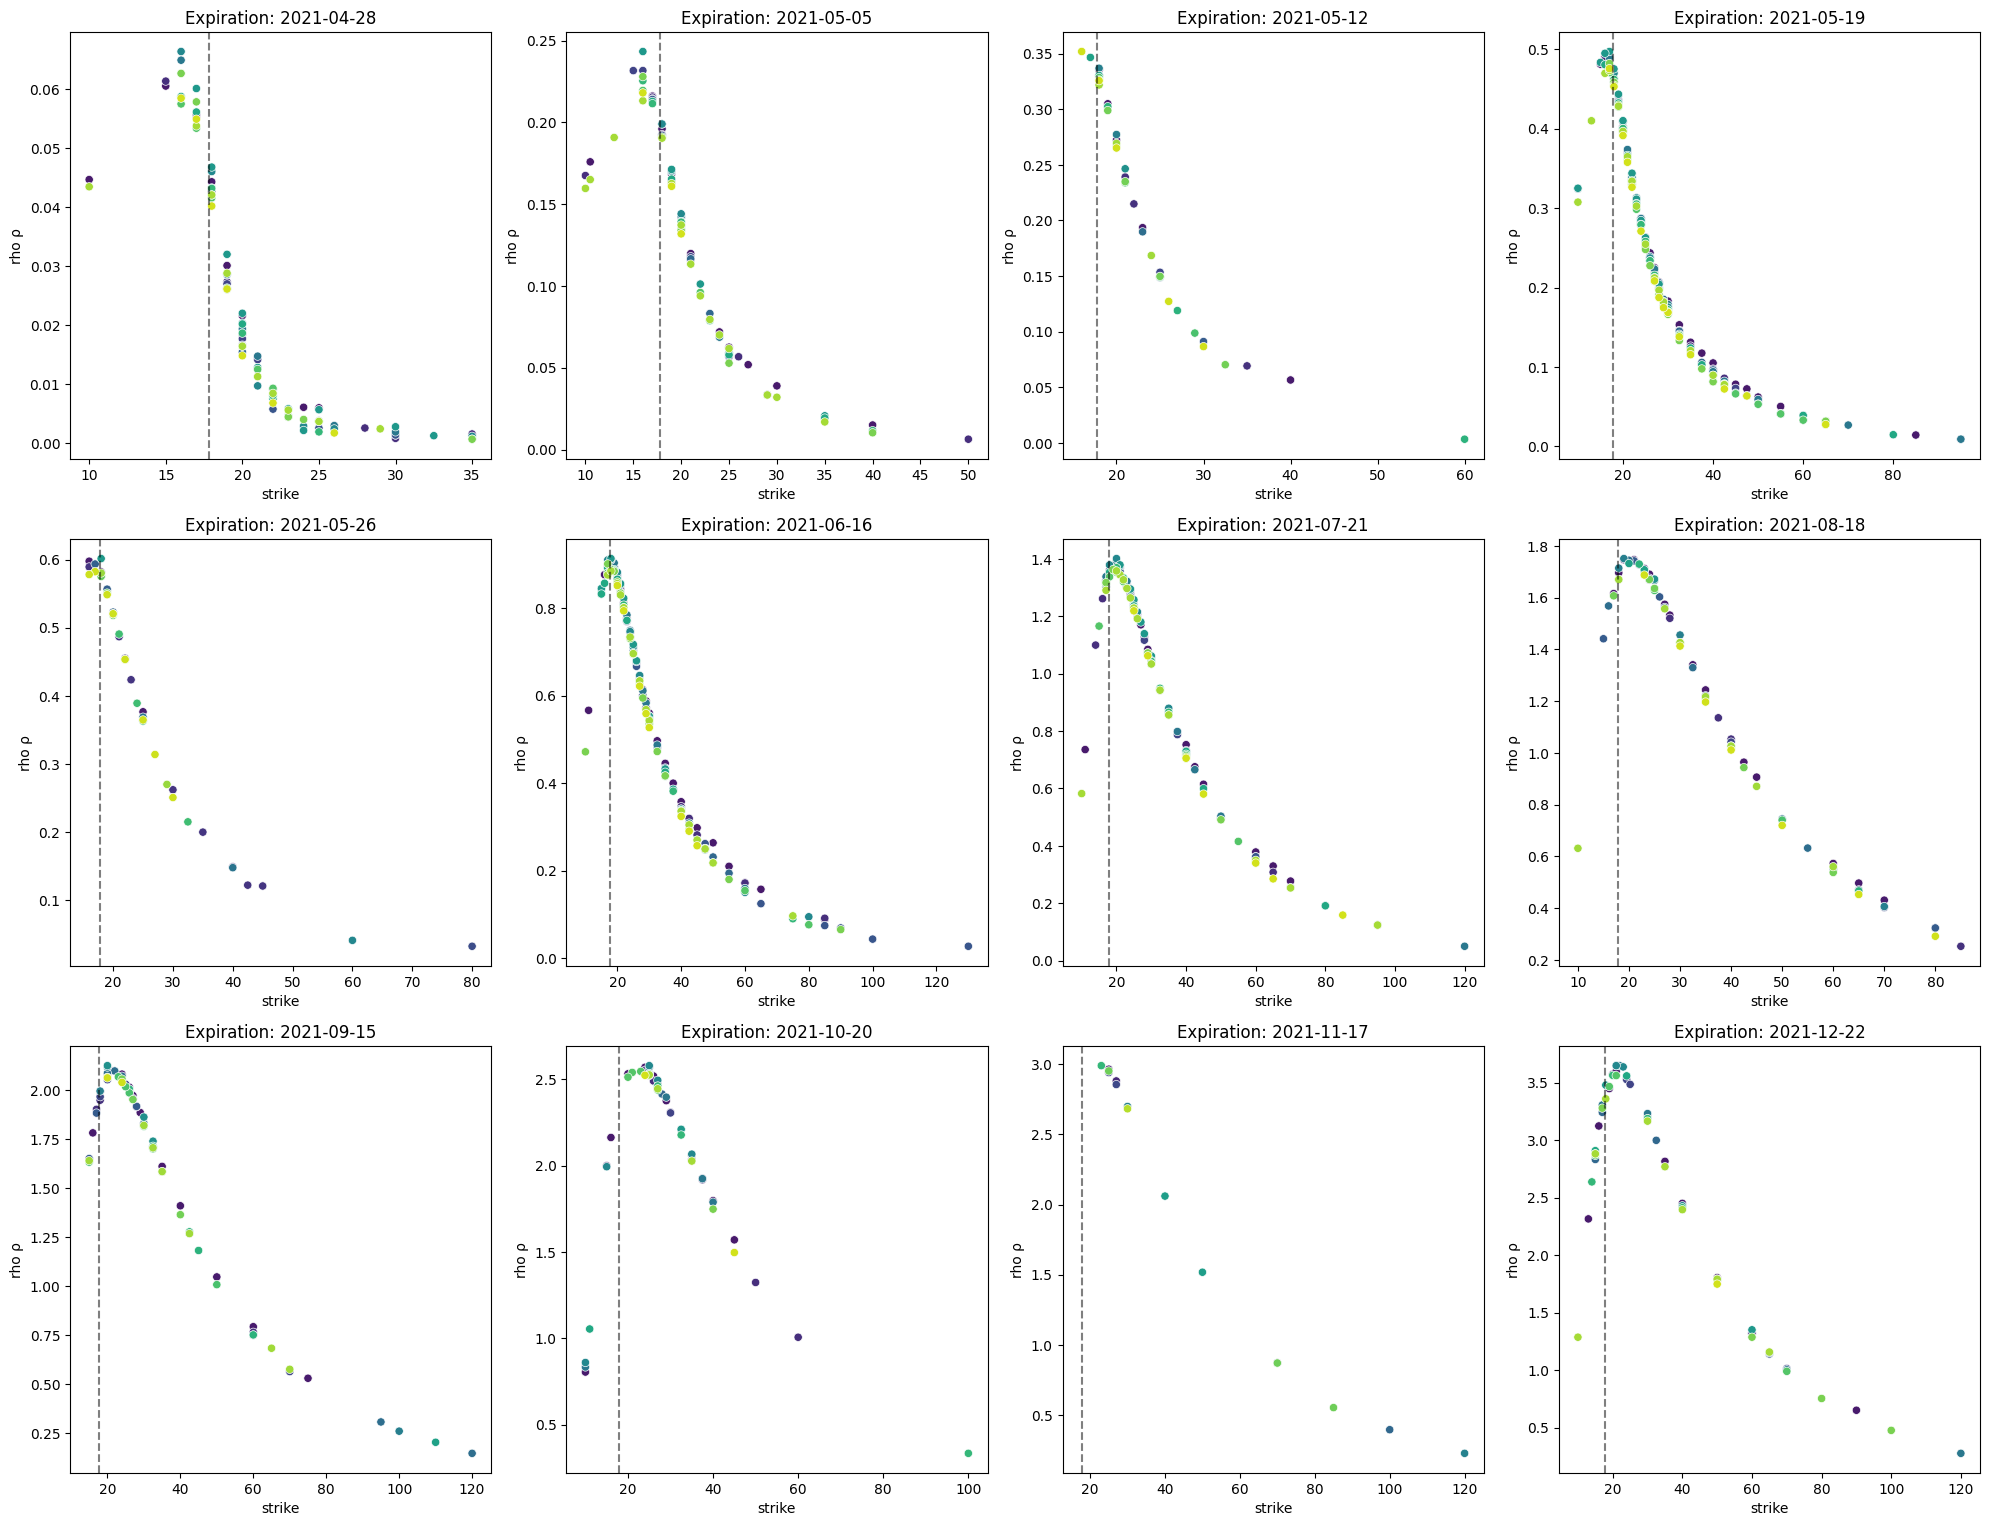

In [285]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='rho', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('rho \u03C1')
    axes[i].set_title(f'Expiration: {expiration}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()